My final project for Brainstation's September 2020 machine learning course. In this project, I do basic data cleaning, logistic regression and PCA for modeling, and use ROC and AUC with F1 scores to evaluate model performance. Finally, I use keras to train a model and improve performance metrics.

Original data from https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction?select=test.csv

In [1]:
#Import all of the packages we think we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
pd.options.display.max_columns=500
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
fp = pd.read_csv('trainfp.csv')

In [3]:
fp.head()
#First lets look at the data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
fp['Policy_Sales_Channel'].value_counts(dropna=False)

152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
          ...  
144.0         1
149.0         1
84.0          1
143.0         1
43.0          1
Name: Policy_Sales_Channel, Length: 155, dtype: int64

In [5]:
fp.isnull().values.any() #A good way to initially check for any NaN values across the entire data set.
#False return means no NaN at all, simplifying your data cleaning.

False

In [6]:
fp['Vintage'].unique() #The days someone has been a customer. Every customer is less than a year old, very suspicious data

array([217, 183,  27, 203,  39, 176, 249,  72,  28,  80,  46, 289, 221,
        15,  58, 147, 256, 299, 158, 102, 116, 177, 232,  60, 180,  49,
        57, 223, 136, 222, 149, 169,  88, 253, 107, 264, 233,  45, 184,
       251, 153, 186,  71,  34,  83,  12, 246, 141, 216, 130, 282,  73,
       171, 283, 295, 165,  30, 218,  22,  36,  79,  81, 100,  63, 242,
       277,  61, 111, 167,  74, 235, 131, 243, 248, 114, 281,  62, 189,
       139, 138, 209, 254, 291,  68,  92,  52,  78, 156, 247, 275,  77,
       181, 229, 166,  16,  23,  31, 293, 219,  50, 155,  66, 260,  19,
       258, 117, 193, 204, 212, 144, 234, 206, 228, 125,  29,  18,  84,
       230,  54, 123, 101,  86,  13, 237,  85,  98,  67, 128,  95,  89,
        99, 208, 134, 135, 268, 284, 119, 226, 105, 142, 207, 272, 263,
        64,  40, 245, 163,  24, 265, 202, 259,  91, 106, 190, 162,  33,
       194, 287, 292,  69, 239, 132, 255, 152, 121, 150, 143, 198, 103,
       127, 285, 214, 151, 199,  56,  59, 215, 104, 238, 120,  2

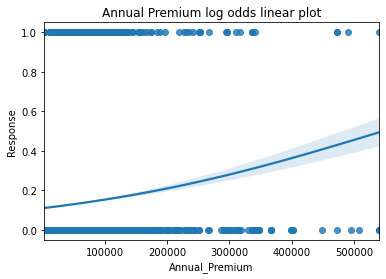

In [8]:
Annual_premium = sns.regplot(x= 'Annual_Premium', y= 'Response', data= fp, logistic= True).set_title("Annual Premium log odds linear plot")
#Not a "U" shape, slight "S" shape Assumption of IV's log odds linearity seems intact

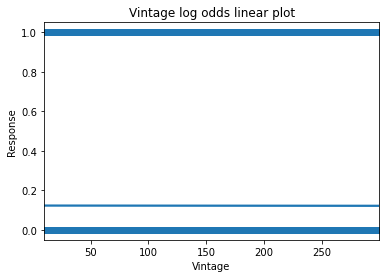

In [11]:
Days_With = sns.regplot(x= 'Vintage', y= 'Response', data= fp, logistic= True).set_title("Vintage log odds linear plot")
#Clearly not S shape, discard

In [3]:
fp['Vehicle_Age'] = fp['Vehicle_Age'].replace({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})

#Consider turning Policy_Sales_Channel into dummy variables
#Consider turning Region_Code into dummy variables

In [4]:
fp['Gender'] = fp['Gender'].replace({'Male':0, 'Female':1})

In [5]:
fp['Vehicle_Damage'] = fp['Vehicle_Damage'].replace({'Yes':0, 'No':1})

In [6]:
from sklearn.cluster import KMeans
#We originally wanted to use KMeans to determine customer segmentation but with responses already known, training a 
#logistic regression model made more sense

For my feature selection, I made the decision to remove "policy sales channel" and "region code" because their numerical values were categorical but I had no information on what each value refered to. I am unable to interpret these variables' meaning. In addition, I remove 'vintage' for failing the linearity assumption of independent variable's log odds.

In [11]:
# Remove 'Policy_Sales_Channel', 'Vintage', and 'Region_Code' because they do not meet conditions and/or do not have clear 
#documentation. In addition, we may have to remove additional variables due to multicollinearity

In [12]:
#Check multicollinearity 
multico = fp.corr()
#Vehicle Age and Age of customer are moderately positively correlated. Older customers have older vehicles. Consider dropping one
#Vehicle Damage and Previously Insured are highly correlated which is not surprising. Consider dropping one term

In [7]:
del fp['Vintage']
del fp['id']
del fp['Region_Code']
del fp['Policy_Sales_Channel']

In [12]:
sns.set(font_scale=1)

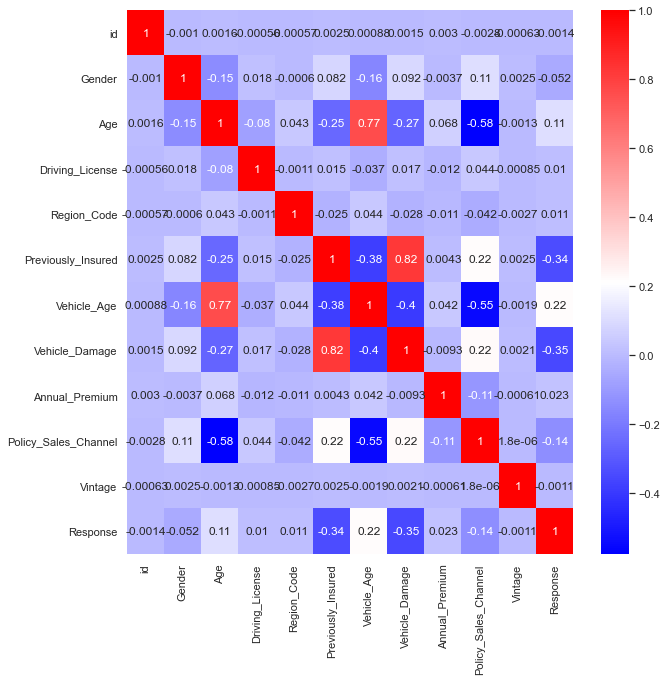

In [16]:
#We are going to make a heat graph of multicollinearity for visual's sake
plt.figure(figsize=(10,10)) 
sns.heatmap(multico, annot = True, cmap = 'bwr')

While using a heatmap to visualize multicollinearity is good, a heatmap should not be used to determine what variables to drop. Instead, I will calculate the variance inflation factor (VIF) to identify which variables are the most correlated. VIF>5 means lots of multicollinearity and VIF > 10 means that there is extreme multicollinearity.

In [8]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [9]:
fpnr = fp.drop(['Response'],axis = 1)

In [10]:
features_to_include = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Age', 'Previously_Insured','Annual_Premium', ]


In [19]:
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data['feature'] = fpnr.columns
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(fpnr.values, i) 
                          for i in range(len(fpnr.columns))] 
  
print(vif_data)

              feature        VIF
0              Gender   1.899458
1                 Age  17.198158
2     Driving_License  14.075008
3  Previously_Insured   5.821599
4         Vehicle_Age   5.809125
5      Vehicle_Damage   6.337200
6      Annual_Premium   4.151380


Out of the 7 features in my data set, 4 of them have VIF scores greater than 5! In order to reduce the VIF score, I will remove the column with the highest score and run the test again.

In [20]:
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data['feature'] = fpnr.drop(['Age'], axis = 1).columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(fpnr.drop(['Age'], axis = 1).values, i) 
                          for i in range(len(fpnr.drop(['Age'], axis = 1).columns))] 
  
print(vif_data)

              feature       VIF
0              Gender  1.897788
1     Driving_License  8.534838
2  Previously_Insured  5.818547
3         Vehicle_Age  2.609965
4      Vehicle_Damage  6.332523
5      Annual_Premium  4.131076


With the removal of age, driving license sees its VIF score drop dramatically while all other scores remain unaffected. This corresponds with our heat map and multicollinearity scores. However, we are much more interested in the age of a customer than whether they have a driving license or not. In fact, we would hope all customers purchasing auto insurance are certified to operate a motor vehicle!

In [21]:
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data['feature'] = fpnr.drop(['Driving_License',], axis = 1).columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(fpnr.drop(['Driving_License'], axis = 1).values, i) 
                          for i in range(len(fpnr.drop(['Driving_License'], axis = 1).columns))] 
  
print(vif_data)

              feature        VIF
0              Gender   1.732599
1                 Age  10.428662
2  Previously_Insured   5.795984
3         Vehicle_Age   5.637297
4      Vehicle_Damage   6.179888
5      Annual_Premium   3.478673


With driving license removed, age's VIF drops heavily but still remains above 10. While worrying, a business is very interested in its customers' demographics so age is here to stay.

In [17]:
fp

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response
0,0,44,1,0,2,0,40454.0,1
1,0,76,1,0,1,1,33536.0,0
2,0,47,1,0,2,0,38294.0,1
3,0,21,1,1,0,1,28619.0,0
4,1,29,1,1,0,1,27496.0,0
...,...,...,...,...,...,...,...,...
381104,0,74,1,1,1,1,30170.0,0
381105,0,30,1,1,0,1,40016.0,0
381106,0,21,1,1,0,1,35118.0,0
381107,1,68,1,0,2,0,44617.0,0


In [11]:
from sklearn.preprocessing import StandardScaler


In [12]:
scaler = StandardScaler()
scaler.fit(fp[features_to_include])
XS = scaler.transform(fp[features_to_include])
#We are going to scale the data because we are going to use PCA for some models
#This is the wrong way of scaling data, but I didn't learn that until after I started

In [21]:
from matplotlib import pyplot

In [25]:
fp['Annual_Premium'].max()

540165.0

(array([3.80973e+05, 1.17000e+02, 1.90000e+01]),
 array([  2630.        , 181808.33333333, 360986.66666667, 540165.        ]),
 <a list of 3 Patch objects>)

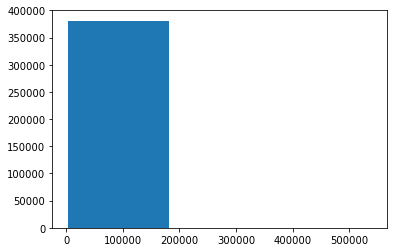

In [27]:
pyplot.hist(fp['Annual_Premium'], bins = 3)

Looking at the histogram and the max value, annual premium is suffering from a very heavy right-skew. Standard scaling which works best on normally distributed data isn't the best choice here. Instead, let's use a more robust scaler.

In [28]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [ ]:
Annual

In [29]:
Annual_Premium_S = scaler.fit_transform(fp['Annual_Premium'].values.reshape(-1,1))

In [30]:
fp['Annual_Premium_S'] = Annual_Premium_S

In [31]:
fp

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response,Annual_Premium_S
0,0,44,1,0,2,0,40454.0,1,0.585862
1,0,76,1,0,1,1,33536.0,0,0.124508
2,0,47,1,0,2,0,38294.0,1,0.441814
3,0,21,1,1,0,1,28619.0,0,-0.203401
4,1,29,1,1,0,1,27496.0,0,-0.278293
...,...,...,...,...,...,...,...,...,...
381104,0,74,1,1,1,1,30170.0,0,-0.099967
381105,0,30,1,1,0,1,40016.0,0,0.556652
381106,0,21,1,1,0,1,35118.0,0,0.230010
381107,1,68,1,0,2,0,44617.0,0,0.863488


In [33]:
features_to_include = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Age', 'Previously_Insured','Annual_Premium_S',]

In [35]:
k_means_model = KMeans(n_clusters = 2)
k_means_model.fit(fp[features_to_include])

KMeans(n_clusters=2)

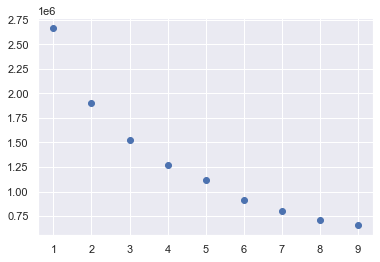

In [38]:
inertia_list = []
k_range = np.arange(1,10)
for k in k_range:
    k_means_model = KMeans(n_clusters = k)
    k_means_model.fit(XS)
    inertia_list.append(k_means_model.inertia_)

plt.scatter(k_range,inertia_list)
plt.show()

In [39]:
#Looks like 2 is the elbow. Let's do k-means with 2, 3, and 4 clusters
four_means_model = KMeans(n_clusters = 4)
four_means_model.fit(XS);

three_means_model = KMeans(n_clusters = 3)
three_means_model.fit(XS);


In [36]:
two_means_model = KMeans(n_clusters = 2)
two_means_model.fit(fp[features_to_include])

KMeans(n_clusters=2)

In [37]:
two_means_model.labels_

array([1, 1, 1, ..., 0, 1, 1])

In [38]:
from sklearn.metrics import accuracy_score


In [39]:
print(accuracy_score(two_means_model.labels_, fp['Response']))

0.5924131941255651


In [40]:
from sklearn.decomposition import PCA


In [41]:
from sklearn import decomposition

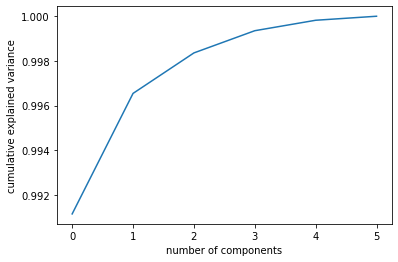

In [42]:
#PCA when we have already scaled down the features manually
pca = PCA().fit(fp[features_to_include])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [47]:
fpnr = fp.drop(['Response', 'Annual_Premium'], axis = 1)

In [48]:
fpnr

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium_S
0,0,44,1,0,2,0,0.585862
1,0,76,1,0,1,1,0.124508
2,0,47,1,0,2,0,0.441814
3,0,21,1,1,0,1,-0.203401
4,1,29,1,1,0,1,-0.278293
...,...,...,...,...,...,...,...
381104,0,74,1,1,1,1,-0.099967
381105,0,30,1,1,0,1,0.556652
381106,0,21,1,1,0,1,0.230010
381107,1,68,1,0,2,0,0.863488


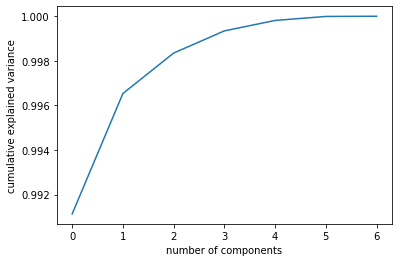

In [49]:
pca = PCA().fit(fpnr)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [53]:

#Build and fit a PCA model to the data
my_pca = PCA(n_components=2)
my_pca.fit(fp[features_to_include])
my_pca_test = PCA(n_components = 2)
my_pca2 = PCA(n_components= 3)
my_pca2.fit(fp[features_to_include])
X_PCA = my_pca.transform(fp[features_to_include])
X2_PCA = my_pca2.transform(fp[features_to_include])


In [54]:
print(X_PCA)

[[ 5.22734630e+00  6.14779629e-01]
 [ 3.71727822e+01  1.88673384e-02]
 [ 8.22516186e+00  4.56816370e-01]
 ...
 [-1.78361123e+01  3.99620022e-01]
 [ 2.92123676e+01  7.84498123e-01]
 [ 7.19015502e+00  7.07738345e-01]]


In [55]:
print(abs(my_pca.components_))

[[0.00468071 0.02801954 0.0086403  0.99951286 0.00819744 0.00501928]
 [0.00363187 0.00669745 0.00733669 0.00464571 0.01305534 0.99984804]]


In [56]:
print(my_pca.explained_variance_ratio_)

[0.99114409 0.00539906]


In [57]:
print(my_pca2.explained_variance_ratio_)

[0.99114409 0.00539906 0.00181405]


Text(0, 0.5, 'pca d 2')

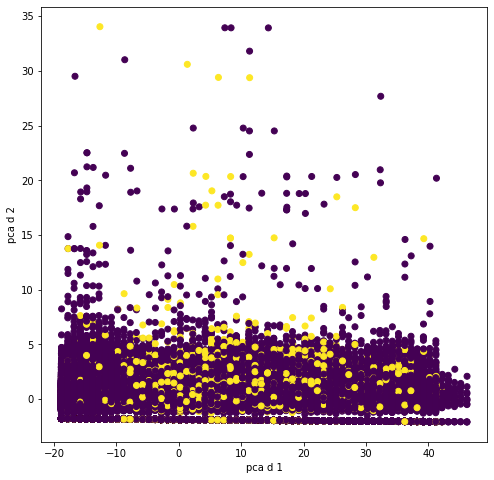

In [58]:
#Ploting the difference in groups determined by PCA. Not a lot of separation
plt.figure(figsize=(8,8))
plt.scatter(X_PCA[:,0], X_PCA[:,1],c=fp['Response'])
plt.xlabel('pca d 1')
plt.ylabel('pca d 2')

In [46]:
X_PCA.shape

(381109, 2)

I used PCA as a follow up to K-means in order to see if I could improve the accuracy of my unsupervised learning. However, both the use of K-means and PCA is flawed as I have already done pre-selection of the variables to include in my model. Using logistic regression makes more sense.

In [59]:
from sklearn.linear_model import LogisticRegression


In [60]:
logreg = LogisticRegression()

In [64]:
from sklearn.model_selection import train_test_split


In [73]:
from sklearn.metrics import f1_score
#A way of checking a model's performance. 0 is bad, 1 is max.

In [76]:
fp['Response'].value_counts()


0    334399
1     46710
Name: Response, dtype: int64

In [77]:
46710 / 334399 #Checking the ratio of success/fails in the dataset. This will be important for when we do weighting

0.13968343206767964

In [82]:
 from sklearn.metrics import confusion_matrix as cs

In [89]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
import tensorflow.keras.backend as K
from keras.optimizers import SGD

import tensorflow as tf
#Here we try Keras

In [90]:
from keras.layers import Dropout        
from tensorflow.keras.utils import to_categorical


In [91]:
#Using stack overflow we find a method of fixing the performance of the model through each epoch
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    #true_positives and possible_positives seem to be misnamed
    return recall
#Sum up the rounded 'clipped' value of y_true multiplied by y_pred, where y_true and y_pred are bounded between 0 and 1
# Because this is log regression, clipping should be redundant as all values are 0 or 1 and any misentered responses should be
#removed during data cleaning
#Recall is 1 when there are no false negatives, lower when there are

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
#Precision is 1 when predicted = true positives
#however unlike recall, precision is looking at how accurately the model predicted positives. It gets lower when there
#are false positives, not false negatives
def keras_f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [98]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(6),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras_f1_score]
    )
    return model

In [99]:
XK = fp[features_to_include]
y = fp['Response']

In [94]:
XK_train, XK_test, yk_train, yk_test = train_test_split(XK, y, test_size=0.2,)

In [95]:
y_nn_train = to_categorical(yk_train)

In [104]:
class_weight2 = {
    0: 1.,
    1: 7.
}
T#he proportions are close to 7:1, so lets make a  model with this weight

In [105]:
model2 = create_model()
model2.fit(XK_train, y_nn_train, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
953/953 - 1s - loss: 0.8826 - keras_f1_score: 0.6698 - val_loss: 0.4777 - val_keras_f1_score: 0.6673
Epoch 2/35
953/953 - 1s - loss: 0.7732 - keras_f1_score: 0.6784 - val_loss: 0.4675 - val_keras_f1_score: 0.6823
Epoch 3/35
953/953 - 1s - loss: 0.7661 - keras_f1_score: 0.6804 - val_loss: 0.4566 - val_keras_f1_score: 0.6894
Epoch 4/35
953/953 - 1s - loss: 0.7625 - keras_f1_score: 0.6833 - val_loss: 0.4745 - val_keras_f1_score: 0.6781
Epoch 5/35
953/953 - 1s - loss: 0.7611 - keras_f1_score: 0.6854 - val_loss: 0.4762 - val_keras_f1_score: 0.6822
Epoch 6/35
953/953 - 1s - loss: 0.7602 - keras_f1_score: 0.6857 - val_loss: 0.4695 - val_keras_f1_score: 0.6873
Epoch 7/35
953/953 - 1s - loss: 0.7588 - keras_f1_score: 0.6855 - val_loss: 0.4698 - val_keras_f1_score: 0.6937
Epoch 8/35
953/953 - 1s - loss: 0.7573 - keras_f1_score: 0.6863 - val_loss: 0.4788 - val_keras_f1_score: 0.6882
Epoch 9/35
953/953 - 1s - loss: 0.7579 - keras_f1_score: 0.6859 - val_loss: 0.4844 - val_keras_f1_score:

In [106]:
predsk2 = model2.predict(XK_test)
predsk2 = np.argmax(predsk2, axis=1)

In [107]:
print(accuracy_score(predsk2, yk_test))
print(f1_score(yk_test, predsk2))
print(roc_auc_score(yk_test, predsk2))

0.6881740180000525
0.4215061091369323
0.7916211136635525


In [108]:
cs(yk_test, predsk2, )

array([[43795, 23102],
       [  666,  8659]], dtype=int64)

With the use of Keras, I have improved the performance of my model through iterative optimizing of the f-1 score

I want to return to PCA using Keras and also with a new approach to training the data. Previously, I scaled the data before the train/test split which is incorrect. This time, I will scale the training set after splitting the data. Why should we do this? Transforming the data transforms the domain. If you transform the entire data set, you are causing overfitting as both the train and test data are shifted into the same domain. This will make your model unreliable when ran against new data.

In [109]:
from statsmodels.api import OLS

In [110]:
X_train, X_test, y_train, y_test = train_test_split(fpnr, y, test_size=0.2,) #Split up training data and test

#Code borrowed from Harvard's CS109A Introduction to Data Science
#Create and fit PCA object
pca = PCA(n_components=3)
pca.fit(X_train)

#Transforming x_train and x_test 
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#Add constant to x_train and x_test. this section of the borrowed code is unnecessary
X_train_pca_cst = sm.add_constant(X_train_pca)
X_test_pca_cst = sm.add_constant(X_test_pca)

#Training
model = LogisticRegression(C=100000).fit(X_train_pca_cst, y_train)

#Predict
y_pred_train = model.predict(X_train_pca_cst)
y_pred_test = model.predict(X_test_pca_cst)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 87.6288592166934%
Testing Set Accuracy: 87.74631996011651%


In [111]:
print(f1_score(y_pred_test, y_test))

0.018907563025210083


In [112]:
print(roc_auc_score(y_test, y_pred_test))

0.5038604932675651


In [113]:
y_nn_train2 = to_categorical(y_train)

In [114]:
def create_model2():
    modelo = tf.keras.Sequential([
        tf.keras.layers.Input(3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    modelo.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras_f1_score]
    )
    return modelo

In [115]:
modelpca = create_model2()
modelpca.fit(X_train_pca, y_nn_train2, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
953/953 - 1s - loss: 0.9065 - keras_f1_score: 0.6780 - val_loss: 0.4912 - val_keras_f1_score: 0.6858
Epoch 2/35
953/953 - 1s - loss: 0.7786 - keras_f1_score: 0.6853 - val_loss: 0.4769 - val_keras_f1_score: 0.6943
Epoch 3/35
953/953 - 1s - loss: 0.7704 - keras_f1_score: 0.6849 - val_loss: 0.4789 - val_keras_f1_score: 0.6806
Epoch 4/35
953/953 - 1s - loss: 0.7672 - keras_f1_score: 0.6862 - val_loss: 0.4631 - val_keras_f1_score: 0.6928
Epoch 5/35
953/953 - 1s - loss: 0.7664 - keras_f1_score: 0.6863 - val_loss: 0.4833 - val_keras_f1_score: 0.6836
Epoch 6/35
953/953 - 1s - loss: 0.7647 - keras_f1_score: 0.6859 - val_loss: 0.4824 - val_keras_f1_score: 0.6860
Epoch 7/35
953/953 - 1s - loss: 0.7645 - keras_f1_score: 0.6860 - val_loss: 0.4892 - val_keras_f1_score: 0.6861
Epoch 8/35
953/953 - 1s - loss: 0.7662 - keras_f1_score: 0.6850 - val_loss: 0.4904 - val_keras_f1_score: 0.6818
Epoch 9/35
953/953 - 1s - loss: 0.7639 - keras_f1_score: 0.6836 - val_loss: 0.4612 - val_keras_f1_score:

In [116]:
predspca = modelpca.predict(X_test_pca)
predspca= np.argmax(predspca, axis=1)

In [117]:
print(accuracy_score(predspca, y_test))
print(f1_score(y_test, predspca))
print(roc_auc_score(y_test, predspca))
#Wow, outperforms the normal logistic model!
#However, keep in mind that we are using more features in this model so it is only natural for 'better' results
#12/08/2020 no longer outperforms normal log model after changes to scaling

0.6842775051822308
0.4185091216624381
0.790619426569171


Now I am going to scale the data and see if there is a difference in performance

In [118]:
X2_train, X2_test, y2_train, y2_test = train_test_split(fpnr, y, test_size=0.2, )

In [119]:
scaler = StandardScaler()
scaler.fit(X2_train)
XS = scaler.transform(X2_train)


In [120]:
scaler.fit(X2_test)
XST = scaler.transform(X2_test)


In [121]:
def create_model3():
    model3 = tf.keras.Sequential([
        tf.keras.layers.Input(3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model3.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras_f1_score]
    )
    return model3

In [122]:
pca2 = PCA(n_components=3)
pca2.fit(XS)

#Transforming x_train and x_test 
XS_train_pca = pca2.transform(XS)
XS_test_pca = pca2.transform(XST)

In [123]:
y_nn_train3 = to_categorical(y2_train)

In [124]:
modelpca = create_model3()
modelpca.fit(XS_train_pca, y_nn_train3, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
953/953 - 1s - loss: 0.8691 - keras_f1_score: 0.6684 - val_loss: 0.5191 - val_keras_f1_score: 0.6499
Epoch 2/35
953/953 - 1s - loss: 0.7906 - keras_f1_score: 0.6672 - val_loss: 0.4668 - val_keras_f1_score: 0.6832
Epoch 3/35
953/953 - 1s - loss: 0.7857 - keras_f1_score: 0.6668 - val_loss: 0.4820 - val_keras_f1_score: 0.6653
Epoch 4/35
953/953 - 1s - loss: 0.7833 - keras_f1_score: 0.6670 - val_loss: 0.4927 - val_keras_f1_score: 0.6787
Epoch 5/35
953/953 - 1s - loss: 0.7829 - keras_f1_score: 0.6664 - val_loss: 0.4937 - val_keras_f1_score: 0.6668
Epoch 6/35
953/953 - 1s - loss: 0.7808 - keras_f1_score: 0.6670 - val_loss: 0.4716 - val_keras_f1_score: 0.6647
Epoch 7/35
953/953 - 1s - loss: 0.7809 - keras_f1_score: 0.6656 - val_loss: 0.4905 - val_keras_f1_score: 0.6721
Epoch 8/35
953/953 - 1s - loss: 0.7807 - keras_f1_score: 0.6656 - val_loss: 0.4742 - val_keras_f1_score: 0.6797
Epoch 9/35
953/953 - 1s - loss: 0.7799 - keras_f1_score: 0.6668 - val_loss: 0.4925 - val_keras_f1_score:

In [125]:
predspca2 = modelpca.predict(XS_test_pca)
predspca2 = np.argmax(predspca2,axis = 1 )

In [126]:
print(accuracy_score(predspca2, y2_test))
print(f1_score(y2_test, predspca2))
print(roc_auc_score(y2_test, predspca2))
#Actually we see a slight performance decrease

0.6729290755949726
0.41621393780442106
0.7900565067670859


In [102]:
fpnr

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel
0,0,44,1,28.0,0,2,0,40454.0,26.0
1,0,76,1,3.0,0,1,1,33536.0,26.0
2,0,47,1,28.0,0,2,0,38294.0,26.0
3,0,21,1,11.0,1,0,1,28619.0,152.0
4,1,29,1,41.0,1,0,1,27496.0,152.0
...,...,...,...,...,...,...,...,...,...
381104,0,74,1,26.0,1,1,1,30170.0,26.0
381105,0,30,1,37.0,1,0,1,40016.0,152.0
381106,0,21,1,30.0,1,0,1,35118.0,160.0
381107,1,68,1,14.0,0,2,0,44617.0,124.0


Now I'm going to test models that use PCA and the reduced feature set

In [127]:
X3_train, X3_test, y3_train, y3_test = train_test_split(fp[features_to_include], y, test_size=0.2, )

In [128]:
scaler.fit(X3_train)
XS3 = scaler.transform(X3_train)


In [129]:
scaler.fit(X3_test)
XS3T = scaler.transform(X3_test)


In [130]:
pca3 = PCA(n_components=3)
pca3.fit(XS3)

#Transforming x_train and x_test 
XS2_train_pca = pca3.transform(XS3)
XS2_test_pca = pca3.transform(XS3T)

In [131]:
y_nn_train4 = to_categorical(y3_train)

In [132]:
modelpca = create_model3()
modelpca.fit(XS2_train_pca, y_nn_train4, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
953/953 - 1s - loss: 0.8915 - keras_f1_score: 0.6615 - val_loss: 0.4972 - val_keras_f1_score: 0.6675
Epoch 2/35
953/953 - 1s - loss: 0.7902 - keras_f1_score: 0.6662 - val_loss: 0.4819 - val_keras_f1_score: 0.6721
Epoch 3/35
953/953 - 1s - loss: 0.7850 - keras_f1_score: 0.6667 - val_loss: 0.4803 - val_keras_f1_score: 0.6718
Epoch 4/35
953/953 - 1s - loss: 0.7835 - keras_f1_score: 0.6668 - val_loss: 0.4821 - val_keras_f1_score: 0.6704
Epoch 5/35
953/953 - 1s - loss: 0.7814 - keras_f1_score: 0.6676 - val_loss: 0.4864 - val_keras_f1_score: 0.6700
Epoch 6/35
953/953 - 1s - loss: 0.7793 - keras_f1_score: 0.6663 - val_loss: 0.4878 - val_keras_f1_score: 0.6759
Epoch 7/35
953/953 - 1s - loss: 0.7796 - keras_f1_score: 0.6664 - val_loss: 0.5036 - val_keras_f1_score: 0.6675
Epoch 8/35
953/953 - 1s - loss: 0.7782 - keras_f1_score: 0.6657 - val_loss: 0.4780 - val_keras_f1_score: 0.6777
Epoch 9/35
953/953 - 1s - loss: 0.7780 - keras_f1_score: 0.6664 - val_loss: 0.4678 - val_keras_f1_score:

In [133]:
predspca3 = modelpca.predict(XS2_test_pca)
predspca3 = np.argmax(predspca3,axis = 1 )

In [134]:
print(accuracy_score(predspca3, y3_test))
print(f1_score(y3_test, predspca3))
print(roc_auc_score(y3_test, predspca3))
#Reduced accuracy and performance which is to be expected with smaller feature set

0.6701214872346567
0.415989222836438
0.7897794049669022


0.6395266458502794
0.378258508327299
0.7498430805761529


In [157]:
print(accuracy_score(predspca2, y2_test))
print(f1_score(y2_test, predspca2))
print(roc_auc_score(y2_test, predspca2))
#compare 

0.6641914407913726
0.4119917298414886
0.7892842050332978


Model with PCA and reduced feature set but no scaling

In [135]:
pca3 = PCA(n_components=3)
pca3.fit(X3_train)

#Transforming x_train and x_test 
X3_train_pca = pca3.transform(X3_train)
X3_test_pca = pca3.transform(X3_test)

In [136]:
modelpca_noscaling = create_model3()
modelpca.fit(X3_train_pca, y_nn_train4, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
953/953 - 1s - loss: 0.8294 - keras_f1_score: 0.6610 - val_loss: 0.4695 - val_keras_f1_score: 0.6791
Epoch 2/35
953/953 - 1s - loss: 0.7711 - keras_f1_score: 0.6797 - val_loss: 0.4497 - val_keras_f1_score: 0.7102
Epoch 3/35
953/953 - 1s - loss: 0.7672 - keras_f1_score: 0.6837 - val_loss: 0.4585 - val_keras_f1_score: 0.7039
Epoch 4/35
953/953 - 1s - loss: 0.7658 - keras_f1_score: 0.6835 - val_loss: 0.4758 - val_keras_f1_score: 0.6908
Epoch 5/35
953/953 - 1s - loss: 0.7648 - keras_f1_score: 0.6850 - val_loss: 0.4692 - val_keras_f1_score: 0.6728
Epoch 6/35
953/953 - 1s - loss: 0.7635 - keras_f1_score: 0.6857 - val_loss: 0.4690 - val_keras_f1_score: 0.6888
Epoch 7/35
953/953 - 1s - loss: 0.7629 - keras_f1_score: 0.6853 - val_loss: 0.4617 - val_keras_f1_score: 0.7039
Epoch 8/35
953/953 - 1s - loss: 0.7634 - keras_f1_score: 0.6856 - val_loss: 0.4732 - val_keras_f1_score: 0.6846
Epoch 9/35
953/953 - 1s - loss: 0.7631 - keras_f1_score: 0.6858 - val_loss: 0.4635 - val_keras_f1_score:

In [137]:
predspca4 = modelpca.predict(X3_test_pca)
predspca4 = np.argmax(predspca4,axis = 1 )

In [138]:
print(accuracy_score(predspca4, y3_test))
print(f1_score(y3_test, predspca4))
print(roc_auc_score(y3_test, predspca4))
#Better than the scaled model

0.6925690745454068
0.4280030268264701
0.7940371449744953


Through optimizing the feature set and transforming the data through PCA, we improve the accurracy and performance metrics f1-score and ROC AUC score for our model in keras.